<a href="https://colab.research.google.com/github/dlike230/CIS520FinalProject/blob/master/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -r requirements.txt

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


**Loading the dataset**

We'll start by loading the dataset, which contains reviews of food products on Amazon and their associated ratings.

In [0]:
from google.colab import files
files.upload()

Saving Reviews.csv to Reviews.csv


Here, we load the dataset into a pandas dataframe. 

In [44]:
import pandas as pd
df = pd.read_csv("./data/Reviews.csv", sep=',', quotechar='"')

KeyboardInterrupt: 

(array([ 52268.,      0.,  29769.,      0.,      0.,  42640.,      0.,
         80655.,      0., 363122.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

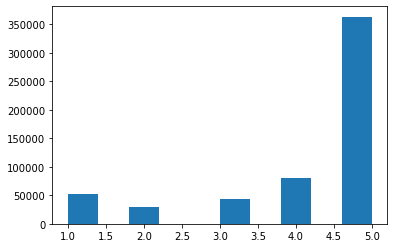

In [12]:
import matplotlib.pyplot as plt
plt.hist(df["Score"])

In [43]:
def extract_text(df):
    return [Soup(text, features="html.parser").get_text() for text in df["Text"]]

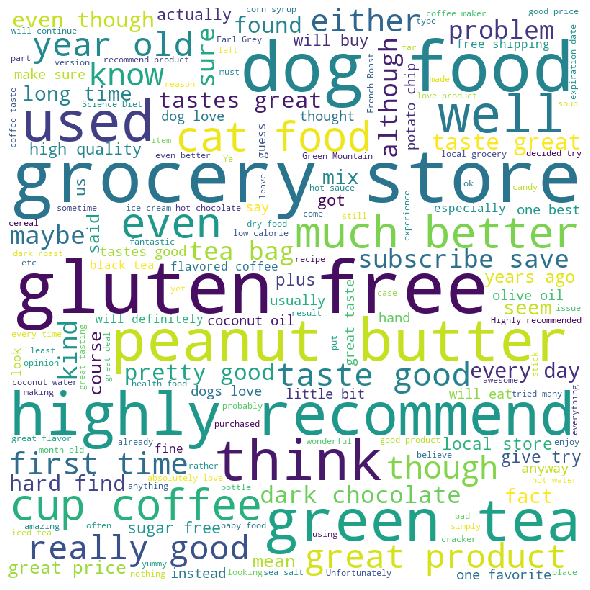

In [18]:
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup as Soup

stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate("\n".join(extract_text(df))) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [1]:
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt


def graph_reconstruction(X, delta = 10, max_components = 1000, print_progress = False):

	frobenii = [np.linalg.norm(X.toarray())]
	rnge = [i for i in range(delta, max_components + delta, delta)]

	for i in rnge:
		dim_reducer = TruncatedSVD(n_components=i)
		shrunk = dim_reducer.fit_transform(X)
		X_reconst = dim_reducer.inverse_transform(shrunk)
		frobenii.append(np.linalg.norm(X - X_reconst))
		if (print_progress):
			print("{}% complete".format(100 * i / max_components))

	components = [0]
	components.extend(rnge)

	plt.plot(components, frobenii)
	plt.show()
	return components, frobenii


def graph_eigenvalues(X):
	X = X.toarray()
	_, s, _ = np.linalg.svd(X)
	values = s
	plt.plot(values)
	plt.show()
	return values

In [2]:
from typing import List

import pandas as pd
from bs4 import BeautifulSoup as Soup
from pandas import DataFrame


def get_df() -> DataFrame:
    return pd.read_csv("./data/Reviews.csv", sep=',', quotechar='"')


def extract_text(df) -> List[str]:
    return [Soup(text, features="html.parser").get_text() for text in df["Text"]]


def balance_dataset(df, label_col, sample_size):
    part1: DataFrame = df[df[label_col] == 1].sample(n=sample_size // 2)
    part2: DataFrame = df[df[label_col] == 0].sample(n=sample_size // 2)
    df = part1.append(part2)
    df = df.sample(frac=1)
    return df


def fetch_data(sample_size=10000):
    raw_df = get_df()
    if sample_size is not None:
        df = raw_df.sample(n=sample_size)
    else:
        df = raw_df
    texts = extract_text(df)
    return texts, df


In [3]:
from typing import List

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

class Vectorizer:

    def __init__(self, pca=True, base_model=TfidfVectorizer(lowercase=True), make_array=False):
        self.base_model = base_model
        self.dimensionality_reducer = None
        self.pca = pca
        self.make_array = make_array

    def fit_transform(self, reviews: List[str]):
        X_train = self.base_model.fit_transform(reviews)
        if self.pca:
            self.dimensionality_reducer = TruncatedSVD(n_components=1000)
            X_train = self.dimensionality_reducer.fit_transform(X_train)
        elif self.make_array:
            X_train = X_train.toarray()
        return X_train

    def transform(self, comments: List[str]):
        if self.pca:
            comments = self.dimensionality_reducer.transform(self.base_model.transform(comments))
        else:
            comments = self.base_model.transform(comments)
            if self.make_array:
                comments = comments.toarray()
        return comments


class Model:

    def __init__(self, vectorizer=Vectorizer(pca=True), model=SVC()):
        self.vectorizer = vectorizer
        self.model = model

    def fit(self, reviews_train: List[str], y_train):
        X_train = self.vectorizer.fit_transform(reviews_train) if self.vectorizer is not None else reviews_train
        self.model.fit(X_train, y_train)

    def predict(self, reviews_test: List[str]):
        X_test = self.vectorizer.transform(reviews_test) if self.vectorizer is not None else reviews_test
        return np.round(np.array(self.model.predict(X_test)))

    def get_params(self, deep = True):
        return {'model' : self.model, 'vectorizer' : self.vectorizer}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [4]:
from pandas import DataFrame
from sklearn.metrics import accuracy_score, fbeta_score, auc
import numpy as np


class Pipeline:
    def __init__(self, label_col, p_train, should_subsample=True, sample_size=20000):
        df = get_df()
        df[label_col] = df[label_col].apply(self.label_func)
        if should_subsample:
            df = balance_dataset(df, label_col, sample_size)
        else:
            df = df.sample(n=sample_size)
        self.text_data = extract_text(df)
        self.labels = df[label_col]
        self.metrics = [accuracy_score, lambda a, b: fbeta_score(a, b, 1)]
        self.p_train = p_train

    def label_func(self, item):
        """
        Takes an item from the label column in the dataset and generates a numerical label to input into the model
        :param item:
        :return:
        """
        raise Exception("Not implemented")

    def make_model(self):
        raise Exception("Not implemented")

    def evaluate(self):
        n_train = int(self.p_train * len(self.text_data))
        reviews_train = self.text_data[:n_train]
        reviews_test = self.text_data[n_train:]
        labels_train = self.labels[:n_train]
        labels_test = self.labels[n_train:]
        model = self.make_model()
        if type(model) == list:
            for model_name, individual_model in model:
                print("MODEL %s" % model_name)
                individual_model.fit(reviews_train, np.array(labels_train))
                predictions = np.round(individual_model.predict(reviews_test))
                for i, score in enumerate(self.metrics):
                    print("Metric", str(i) + ":", score(predictions, np.array(labels_test)))
        else:
            model.fit(reviews_train, np.array(labels_train))
            predictions = np.round(model.predict(reviews_test))
            for i, score in enumerate(self.metrics):
                print("Metric", str(i) + ":", score(predictions, np.array(labels_test)))


Dumb baseline model, predicts majority class of training data

In [5]:
class Dumb:
    def __init__(self):
        self.model = None

    def fit(self, train_strings, y_train):
        c1 = 0
        for y in y_train:
            if y == 0:
                c1 += 1
        c2 = len(y_train) - c1
        self.model = 0 if c1 > c2 else 1

    def predict(self, reviews_test):
        return [self.model] * len(reviews_test)

    def get_params(self, deep = True):
        return {'model' : self.model}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


BERT model

In [6]:
import ktrain
from ktrain import text
import matplotlib.pyplot as plt
import tensorflow as tf

class BERT:
    def __init__(self):
        self.model = None
        self.learner = None
        self.predictor = None

    def fit(self, train_strings, y_train):
        tf.random.set_random_seed(0)
        (x_train, y_train), (x_test, y_test), preproc = \
            text.texts_from_array(train_strings, y_train, class_names=["low", "high"], preprocess_mode="bert", maxlen=300, lang="en")
        self.model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
        learner = ktrain.get_learner(self.model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=12)
        self.learner = learner
        learner.fit_onecycle(1e-5,1)
        learner.plot('loss')
        plt.show()
        self.predictor = ktrain.get_predictor(learner.model, preproc)

    def find_lr(self):
        self.learner.lr_find(max_epochs=1, show_plot=True)
        plt.show()
        

    def predict(self, reviews_test):
        return [(0 if i == 'low' else 1) for i in self.predictor.predict(reviews_test)]

    def get_params(self, deep = True):
        return {'model':self.model, 'learner':self.learner, 'predictor':self.predictor}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


c:\users\owen\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\owen\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\owen\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\owen\appdata\

using Keras version: 2.2.4


RNN model

In [8]:
import os

import numpy as np
import tensorflow as tf

from text_encoders.CharacterEncoder import CharacterRNNEncoder
from text_encoders.WordEncoder import WordEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


class RNN:

    def __init__(self, encode_words=True):
        if encode_words:
            self.encoder = WordEncoder()
        else:
            self.encoder = CharacterRNNEncoder()
        self.model = None

    def fit(self, train_strings, y_train):
        val_size = round(len(train_strings) * 0.5)
        train_strings, val_strings = train_strings[:val_size], train_strings[val_size:]
        X_train = self.encoder.fit_transform(train_strings)
        y_train, y_val = y_train[:val_size], y_train[val_size:]
        X_val = self.encoder.transform(val_strings)
        vocab_size = self.encoder.vocab_size
        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size + 2, 64),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(1e-4),
                           metrics=[
                               tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall'),
                               tf.keras.metrics.AUC(name='auc'),
                           ])
        self.model.fit(x=X_train, y=np.array([1 if item else 0 for item in y_train]), epochs=5,
                       validation_data=(X_val, np.array([1 if item else 0 for item in y_val])), validation_steps=10)

    def predict(self, reviews_test):
        return [prediction[0] for prediction in self.model.predict(self.encoder.transform(reviews_test))]

    def get_params(self, deep = True):
        return {'model':self.model, 'encoder':self.encoder}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Word Embedding model (based on Word2Vec)

In [10]:
import tensorflow as tf


class WordEmbeddingModel:

    def fit(self, vectors, train_labels):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, input_dim=vectors.shape[1], activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(1e-4),
                           metrics=[
                               tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall'),
                               tf.keras.metrics.AUC(name='auc'),
                           ])
        self.model.fit(x=vectors, y=train_labels, epochs=2)

    def predict(self, vectors):
        return self.model.predict(vectors)

    def get_params(self, deep = True):
        return {'model':self.model}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


Bulk pipeline for running multiple models

In [11]:
class BulkPipeline(Pipeline):

    def __init__(self, models, names):
        super().__init__("Score", 0.5)
        self.models = models
        self.names = names

    def make_model(self):
        return list(zip(self.names, self.models))

    def label_func(self, item):
        return 1 if item > 3 else 0


Instantiate and evaluate the baseline models

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

baseline_models = [Dumb(), Model(model=GaussianNB(), vectorizer=Vectorizer(make_array=True)), 
                   Model(model=LogisticRegression(), vectorizer=Vectorizer())]
baseline_names = ["Dumb baseline", "Naive Bayes", "Logistic Regression"]

pipeline = BulkPipeline(baseline_models, baseline_names)
pipeline.evaluate()


MODEL Dumb baseline
Metric 0: 0.4989
Metric 1: 0.0
MODEL Naive Bayes


c:\users\owen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Metric 0: 0.6459
Metric 1: 0.6918994170364571
MODEL Logistic Regression


c:\users\owen\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Metric 0: 0.8252
Metric 1: 0.8241094787683638


The dumb baseline and Naive Bayes classifier are both pretty bad, but the logistic regression works pretty well. Now,
we will experiment with some other models and look closer into logistic regression.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

vect = Vectorizer(pca=True)

experimental_models = [Model(model=SVC(), vectorizer=vect), Model(model=AdaBoostClassifier, vectorizer=vect), 
                      Model(model=GradientBoostingClassifier(), vectorizer = vect), 
                       Model(model = RandomForestClassifier(), vectorizer = vect), RNN(encode_words=True),
                      Model(model=WordEmbeddingModel(), vectorizer=Vectorizer(pca=False, base_model=CountVectorizer())), 
                      BERT()]
experimental_models_names = ['SVM', 'AdaBoost Classifier', 'Gradient Tree Boosting Classifier', 'Random Forest',
                             'RNN', 'Unigram Neural Net', 'BERT']


pipeline = BulkPipeline(experimental_models, experimental_models_names)
pipeline.evaluate()


MODEL SVM


c:\users\owen\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Let's look closer into logistic regression and tune hyperparameters. Here, we use the elastic net penalty and iterate over the
hyperparameters.

In [16]:

log_zipped = [("Logistic: pca: %s, C: %s, l1_ratio: %s" % (pca, val, rat), Model(model=LogisticRegression(C=val, penalty=
                                                                'elasticnet', solver='saga', l1_ratio=rat),
                                                                vectorizer=Vectorizer(pca=pca == 1))) for pca in
                range(1) for val in [0.25, 0.5, 1, 1.5, 2, 4, 8, 16, 32] for rat in [0, .25, .5, .75, 1]]

log_models = []
log_names = []

for n,l in log_zipped:
    log_names.append(n)
    log_models.append(l)

pipeline = BulkPipeline(log_models, log_names)
pipeline.evaluate()


MODEL Logistic: pca: 0, C: 0.25, l1_ratio: 0
Metric 0: 0.8241
Metric 1: 0.821294320837143
MODEL Logistic: pca: 0, C: 0.25, l1_ratio: 0.25
Metric 0: 0.8084
Metric 1: 0.8056795131845842
MODEL Logistic: pca: 0, C: 0.25, l1_ratio: 0.5
Metric 0: 0.797
Metric 1: 0.793615290768605
MODEL Logistic: pca: 0, C: 0.25, l1_ratio: 0.75
Metric 0: 0.7882
Metric 1: 0.7841418671015083
MODEL Logistic: pca: 0, C: 0.25, l1_ratio: 1
Metric 0: 0.784
Metric 1: 0.7788697788697788
MODEL Logistic: pca: 0, C: 0.5, l1_ratio: 0
Metric 0: 0.8343
Metric 1: 0.8310045894951555
MODEL Logistic: pca: 0, C: 0.5, l1_ratio: 0.25
Metric 0: 0.8266
Metric 1: 0.8230973270761069
MODEL Logistic: pca: 0, C: 0.5, l1_ratio: 0.5
Metric 0: 0.8193
Metric 1: 0.815781425221735
MODEL Logistic: pca: 0, C: 0.5, l1_ratio: 0.75
Metric 0: 0.8152
Metric 1: 0.8114285714285714
MODEL Logistic: pca: 0, C: 0.5, l1_ratio: 1
Metric 0: 0.8107
Metric 1: 0.8061840892802293
MODEL Logistic: pca: 0, C: 1, l1_ratio: 0
Metric 0: 0.8408
Metric 1: 0.8379808670873

This hyperparameter search reveals that a C value of 8 and an l1_ratio of .25 are ideal, yielding the highest metrics:
Metric 0: 0.8418
Metric 1: 0.8401051142106326
Now, we will see if utilizing pca results in improvement:

In [17]:
pipeline = BulkPipeline([Model(model=LogisticRegression(C=8, penalty='elasticnet', solver='saga', l1_ratio=0.25),
                        vectorizer=Vectorizer(pca=True))], ['Log Reg with PCA'])
pipeline.evaluate()


MODEL Log Reg with PCA
Metric 0: 0.8309
Metric 1: 0.8276424421567629


It does not.

Let's try auto-sklearn. Note: this can only be run on a UNIX system, so the following two blocks are not shown executed, since we are using Windows machines. We executed this code in a separate Linux environment, and reported the results below.

In [ ]:
!pip install auto-sklearn

In [ ]:
from autosklearn.classification import AutoSklearnClassifier

pipeline = BulkPipeline([Model(model=AutoSklearnClassifier(), vectorizer=Vectorizer(pca=True))], ['auto sklearn'])
pipeline.evaluate()

We saw these results:
Metric 0: 0.8378
Metric 1: 0.83526

Not bad, it beats the baseline logistic regression. However, with hyperparameter tuning, we beat it. So, we will not move forward with auto-sklearn.

So, our results indicate that BERT and Logistic Regression are our best two models. BERT is significantly better than 
Logistic Regression, but Logistic Regression beats everything else.